A training, validation, and testing dataset is required for these reasons: 
Training data is used to decide the optimal hyperparameters for the model. These are usually the hyperparameters that result in the lowest error in the difference between what the model predicts and the actual ground truth value. 
Validation data is used in conjunction with training data to tell the model when to stop training and optimising hyperparameters with respect to the error in the training loss. This does so to prevent overfitting by stopping training when the validation error (which is not used directly to decide optimal hyperparameters) starts to increase (at this point the model is beginning to overfit and will result in high errors in the test data). 
Test data is used to see how well our model generalises to unseen data. If the test error is high but the training error is low, this means our model does not generalise well and is optimised only for the data it was trained on. However, if the training error and test error are both low, this means our model can perform very on unseen data and generalises well. It has therefore captured the trend in the entire dataset, rather than capturing the trends found in the training dataset only. 

In [33]:
import glob
import numpy as np
import matplotlib.pyplot as plt

# Load in colour images 
files = glob.glob("apples/*.jpg")
ColorImgs = []
for myFile in files:
    im = plt.imread(myFile)
    # Normalising pixel intensity between 0 and 1
    im = im /255
    ColorImgs.append(im)

# Load in masks 
files = glob.glob("apples/*.png")
masks = []
for myFile in files:
    im = plt.imread(myFile)
    im = im[:, :, 0]
    masks.append(im)

# loop through each image in the mask array and threshold each pixel to create a binary mask 
apple_mask_bin_arr = []
non_apple_mask_bin_arr = []

for ind, image in enumerate(masks):
    x, y = image.shape
    apple_mask = np.zeros((x, y))
    non_apple_mask = np.zeros((x, y))
    RGBApples = []
    RGBNonApples = []

    for i in range(x):
        for j in range(y):
            if image[i, j] > 0.5:
                apple_mask[i, j] = 1
                non_apple_mask[i, j] = 0
            else: 
                apple_mask[i, j] = 0
                non_apple_mask[i, j] = 1


    apple_mask = np.reshape(apple_mask, (x, y)).astype(int)
    apple_mask_bin_arr.append(apple_mask)
    non_apple_mask = np.reshape(non_apple_mask, (x, y)).astype(int)
    non_apple_mask_bin_arr.append(non_apple_mask)


Text(0.5, 1.0, 'Ground truth')

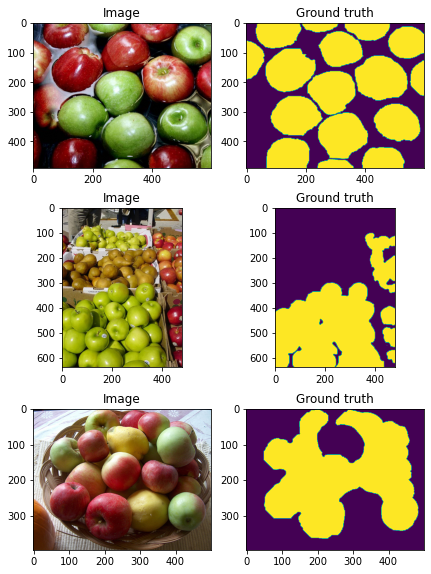

In [34]:
# display the test image and the ground truth mask

f, ax = plt.subplots(3, 2, figsize=(7,10))
ax[0][0].imshow(ColorImgs[0])
ax[0][0].set_title('Image')
ax[1][0].imshow(ColorImgs[1])
ax[1][0].set_title('Image')
ax[2][0].imshow(ColorImgs[2])
ax[2][0].set_title('Image')
ax[0][1].imshow(masks[0])
ax[0][1].set_title('Ground truth')
ax[1][1].imshow(masks[1])
ax[1][1].set_title('Ground truth')
ax[2][1].imshow(masks[2])
ax[2][1].set_title('Ground truth')

883800
(883800,)


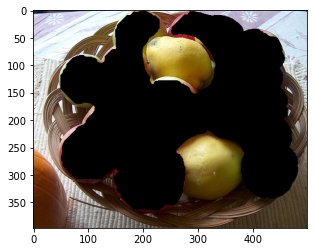

In [35]:
# using the binary masks to index the apple pictures to get a picture of apples with no background (apples_color) and background with no apple (no_apples_color)

import copy

apples_color_arr = []
apples_color = copy.deepcopy(ColorImgs)

# looping through each channel of my colour images and multiplying the corresponding masks for background and non background by each channel 
for idx, image in enumerate(apples_color):
    for channel in range(apples_color[idx].shape[2]):
        apples_color[idx][:, :, channel] = image[:, :, channel] * apple_mask_bin_arr[idx]
    apples_color_arr.append(apples_color[idx])

# repeating for the non apple colour images 
non_apples_color_arr = []
non_apples_color = copy.deepcopy(ColorImgs)

for idx, image in enumerate(non_apples_color):
    for channel in range(non_apples_color[idx].shape[2]):
        non_apples_color[idx][:, :, channel] = image[:, :, channel] * non_apple_mask_bin_arr[idx]
    non_apples_color_arr.append(non_apples_color[idx])

# an example of 
plt.imshow(non_apples_color_arr[2])


RGBNonApples = []
for image in non_apples_color_arr:
    # print(image.shape)
    RGBNonApples.append(image.flatten())

RGBApples = []
for image in apples_color_arr:
    RGBApples.append(image.flatten())



In [91]:
#the goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim,nData = data.shape
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
        
    like = (1 / ((2 * np.pi) ** (nDim / 2)) * (np.linalg.det(gaussCov) ** 0.5)) ** (-0.5 * np.transpose(data - gaussMean) @ np.linalg.inv(gaussCov) @ (data - gaussMean))    
    return like

In [92]:
def getMixGaussLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    Like -- n by 1 matrix
    
    """
    # initialize ikelihoods                                                                       
    like = np.zeros((data.shape[1], ))                                                                               
    for k in range(mixGaussEst['k']):
        prob = calcGaussianProb(data, mixGaussEst['mean'][:,k], mixGaussEst['cov'][:,:,k]) 
        like += mixGaussEst['weight'][k] * prob

    return  like

In [113]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims = data.shape


    postHidden = np.zeros(shape=(k, nDims[1]))

    mixGaussEst = dict()
    mixGaussEst['d'] = nDims[0]
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims[0], k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims[0], nDims[0], k))
    
    for cGauss in range(k):
        # regularisation term added to mitigate chance of singular matrix error 
        mixGaussEst['cov'][:, :, cGauss] = 1000 + 500 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    # TO DO (j) starts here - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # TO DO : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:


            for no_gauss in range(mixGaussEst['k']):
                postHidden[no_gauss, cData] = mixGaussEst['weight'][no_gauss] * calcGaussianProb(data[:, cData],mixGaussEst['mean'][:, no_gauss], mixGaussEst['cov'][:, :, no_gauss])
            
            postHidden[:, cData] = postHidden[:, cData]/np.sum(postHidden[:,cData])

        # ===================== =====================
        # Maximization Step
        # ===================== =====================

        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO :  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / np.sum(postHidden)            
            
            # TO DO :  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = np.sum(postHidden[cGauss, :] * data, axis=1) / (np.sum(postHidden[cGauss, :]))
            
            
            # TO DO :  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian

            mixGaussEst['cov'][:,:,cGauss] = (postHidden[cGauss, :] * (data[:, :] - np.vstack(mixGaussEst['mean'][:, cGauss])) @ (data[:, :] - np.vstack(mixGaussEst['mean'][:, cGauss])).T)/ np.sum(postHidden[cGauss,:]) 
        drawEMData2d(data, mixGaussEst)

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

In [114]:
# define the data that we'll be fitting 
# RGBApples is a list of the masked colour images only showing the apples in colour 
# RBGNonApples is a list of the masked colour images only showing background in colour 

RGBApples = apples_color_arr
RGBNonApples = non_apples_color_arr

# define the number of Gaussians to fit to the data 
gaussComponents = 3

# fit mixture of Gaussians model to data
for i in range(len(RGBNonApples)):
    mixGaussEstApples = fitMixGauss(RGBApples[i], gaussComponents)
    mixGaussEstNonApples = fitMixGauss(RGBNonApples[i], gaussComponents)




TypeError: 'tuple' object cannot be interpreted as an integer

3


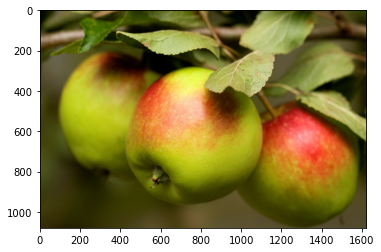

In [44]:
testImage = glob.glob("testApples/*.jpg") 

testImgs = [] 
for myFile in testImage:     
    im = plt.imread(myFile)
    testImgs.append(im) 


plt.figure()
plt.imshow(testImgs[1])

In [99]:
# defining prior
priorApple = 0.5
# calculating posterior
priorNonApple = 1 - priorApple
posteriorApple = []
for i in range(len(testImgs)):
    im = testImgs[i]
    imY, imX, imZ = im.shape
    likeApple = getMixGaussLike(im, mixGaussEstApples)
    likeNonApple = getMixGaussLike(im, mixGaussEstNonApples)
    posterior = (likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
    posterior = np.reshape(posterior, (imY, imX))
    posteriorApple.append(posterior)

posteriorApple = CalculatePosterior(testImgs,priorApple)
# plt.imshow(posteriorApple[0])

NameError: name 'mixGaussEstApples' is not defined